In [1]:
%pylab inline
from astropy.io import fits
import astropy.units as u
import pickle as pickle
import os as os
import pandas as pd

from spectools_ir.utils import extract_hitran_data, spec_convol, make_rotation_diagram, get_molmass
from spectools_ir.utils import compute_thermal_velocity, sigma_to_fwhm, fwhm_to_sigma, wn_to_k, spec_convol_R
from spectools_ir.utils import get_miri_mrs_resolution, get_miri_mrs_wavelengths, make_miri_mrs_figure

from spectools_ir.flux_calculator import calc_fluxes, make_lineshape

from spectools_ir.slabspec import make_spec

from spectools_ir.slab_fitter import Config, LineData,Retrieval
from spectools_ir.slab_fitter import corner_plot, trace_plot, find_best_fit, compute_model_fluxes
from spectools_ir.slab_fitter import calc_solid_angle, calc_radius
from spectools_ir.slab_fitter import read_data_from_file, get_samples

Populating the interactive namespace from numpy and matplotlib


In [2]:
import spectools_ir
spectools_ir.__file__

'/Users/erichegonzales/opt/anaconda3/lib/python3.8/site-packages/spectools_ir/__init__.py'

# Flux_calculator example use

Flux calculator will loop through a set of provided wavelengths, then perform a Gaussian and numerical computation of line flux at each location.  If one begins by using the helper tool "extract_hitran_data", the output will include transition-specific data in addition to the computed line fluxes.

### Read in HITRAN data with extract_hitran_data

This example uses extract_hitran_data to find fundamental CO vibrational transitions in the M band.  A spectrum is read in from a FITS file.

In [3]:
hitran_data=extract_hitran_data('CO',4.58,5.2,vup=1)  #Outputs an astropy table

In [4]:
#Read in FITS data containing spectrum.
infile='nirspec_hd135344_glue.dat'  #my file name
wave,flux = np.loadtxt(infile, unpack=True, skiprows=29) #make sure to skip correct amount of rows in data set

Text(0, 0.5, 'Flux [Jy]')

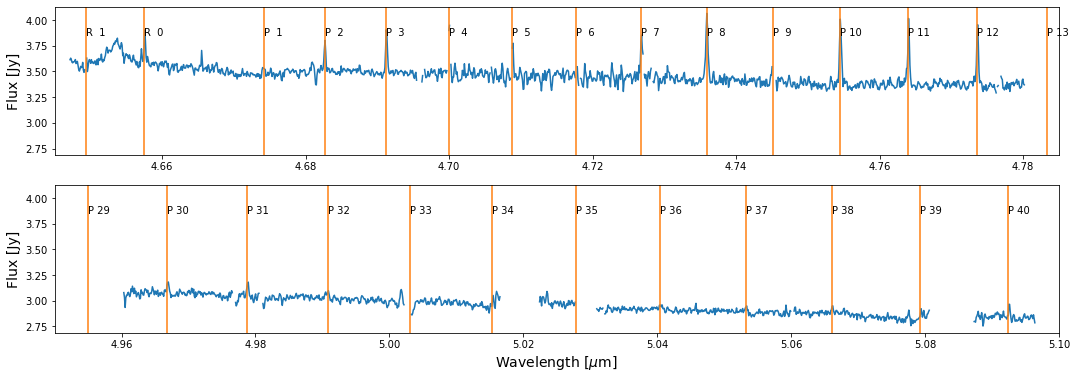

In [5]:
#Plot spectrum.
fig=plt.figure(figsize=(18, 6))

ax1=fig.add_subplot(211)
ax1.plot(wave,flux)
ax1.set_xlim(4.645,4.785)
for i,mywave in enumerate(hitran_data['wave']):
    if( (mywave>4.645) & (mywave<4.785) ):
        ax1.axvline(mywave,color='C1')
        ax1.text(hitran_data['wave'][i],3.85,hitran_data['Qpp'][i].strip())
ax1.set_ylabel('Flux [Jy]',fontsize=14)

ax2=fig.add_subplot(212)
ax2.plot(wave,flux)
ax2.set_xlim(4.95,5.10)
for i,mywave in enumerate(hitran_data['wave']):
    if( (mywave>4.95) & (mywave<5.10) ):
        ax2.axvline(mywave,color='C1')
        ax2.text(hitran_data['wave'][i],3.85,hitran_data['Qpp'][i].strip())
ax2.set_xlabel('Wavelength [$\mu$m]',fontsize=14)
ax2.set_ylabel('Flux [Jy]',fontsize=14)

In [6]:
#How to fix where P/R labels are? Change value next to hitran_data in ax2.text

### Calculate line fluxes for dataset, using locations specified in hitran dataset

calc_fluxes is now used to compute the line fluxes in the spectrum.  (Some additional code is added to read and write in the flux values for use in later parts of this notebook.)  Users can provide input values of the continuum level (cont), FWHM (fwhm_v) and Doppler shift of lines relative to vacuum rest wavelength (v_dop).  Users can also choose the size of the fit interval (sep_v), whether or not to vet the fits (vet_fits; highly recommended) and whether or not to plot (highly recommended).   The routine does little to no vetting on its own, so user vetting is highly recommended.

Not enough data near  5.188832991307322  microns. Skipping.
Not enough data near  5.174610132181797  microns. Skipping.
Not enough data near  5.1605403403369  microns. Skipping.
Not enough data near  5.146622185237298  microns. Skipping.
Not enough data near  5.132854236347658  microns. Skipping.
Not enough data near  5.119235063132647  microns. Skipping.
Not enough data near  5.105763711902044  microns. Skipping.


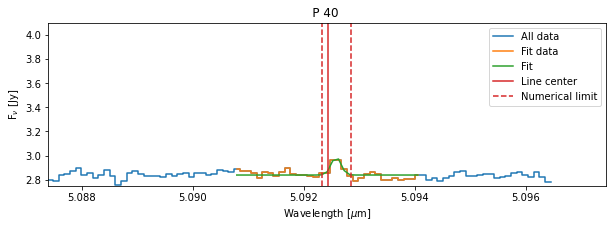

Is this fit okay? [y or n]n


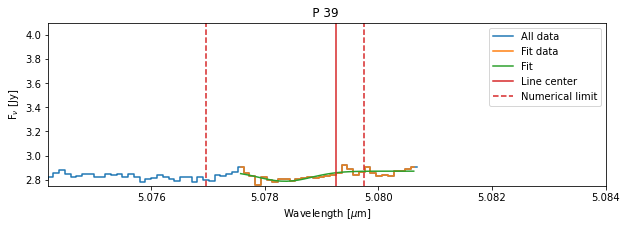

Is this fit okay? [y or n]n


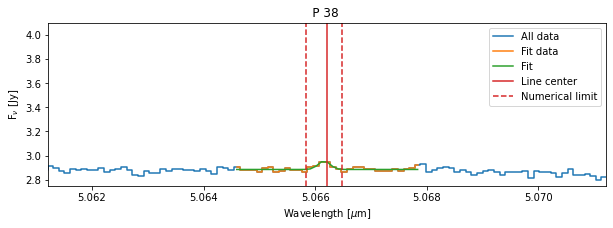

Is this fit okay? [y or n]y


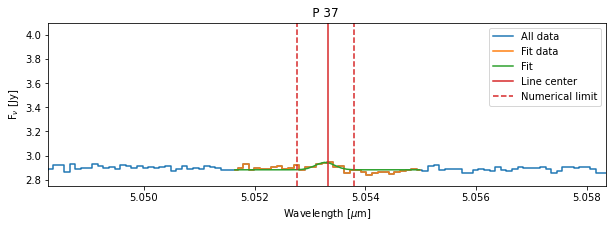

Is this fit okay? [y or n]y


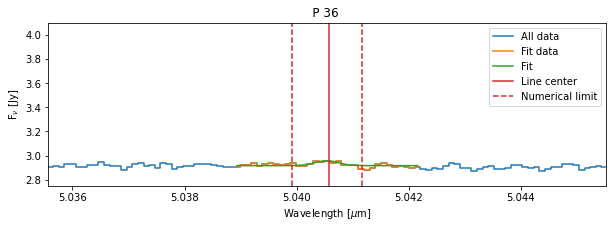

Is this fit okay? [y or n]y
Error - curve_fit failed


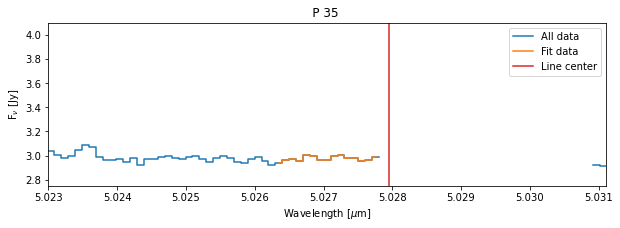

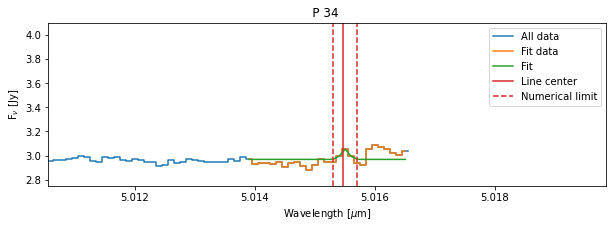

Is this fit okay? [y or n]n
Error - curve_fit failed


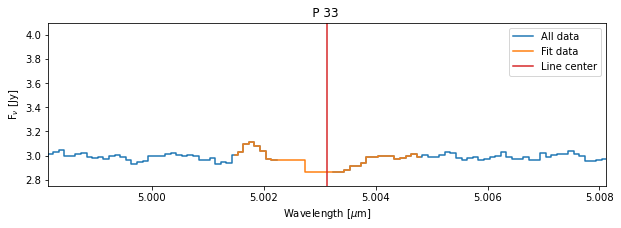

In [ ]:
#Calculate fluxes.
#Uncomment the following two lines to run the code
lineflux_data=calc_fluxes(wave,flux,hitran_data, v_dop=5,fwhm_v=10.,sep_v=100.,cont=0.5,vet_fits=True, plot=True, ymin=2.75, ymax=4.1)
pickle.dump(lineflux_data,open('hd135344_lineflux_data.p','wb')) #save for convenience

#lineflux_data=pickle.load(open('hd135344_lineflux_data.p','rb'))  #restore lineflux_data if you don't want to re-run

In [8]:
#Removed P40, P39, P35, P34, P33, P9, P6, P5, P4, R1

Note that flux_calculator calculates fluxes using both a Gaussian fit and numerical integration.  The numerical integration sums from -3$\sigma$ to +3$\sigma$, where $\sigma$ is provided by the Gaussian fit. These values should be similar for Gaussian line shapes, but may be quite different for more complex line shapes, as for AA Tau. 

The figure below shows how the two compare for this example.

In [9]:
lineflux_data

molec_id,local_iso_id,wn,a,elower,Vp_HITRAN,Vpp_HITRAN,Qp_HITRAN,Qpp_HITRAN,gup,glow,nu,eup_k,wave,lineflux,lineflux_Gaussian,lineflux_err,linewidth,linewidth_err,v_dop_fit,v_dop_fit_err,continuum,continuum_err
,,,,,,,,,,,,,,W / m2,,W / m2,km / s,km / s,km / s,km / s,Jy,Jy
int32,int32,float32,float32,float32,bytes15,bytes15,bytes15,bytes15,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64
5,1,1973.8915,13.89,2835.7627,1,0,,P 38,75.0,77.0,59175780000000.0,6920.019,5.0661345,2.3048837121535836e-18,2.216456352651458e-18,4.936481722255175e-19,14.899580568445245,3.6680381270046634,1.5203473627487327,1.517098285259333,2.884802801777561,0.002467704051374425
5,1,1978.9287,13.99,2690.9912,1,0,,P 37,73.0,75.0,59326790000000.0,6718.9727,5.0532393,2.4782538866240347e-18,2.7148219702890486e-18,8.747344931537385e-19,21.718768990467748,6.447338766229286,2.462214217120983,2.6537244683660415,2.886315227634133,0.003082538279505483
5,1,1983.9363,14.09,2549.962,1,0,,P 36,71.0,73.0,59476917000000.0,6523.2676,5.0404844,2.7783363843740313e-18,2.843447632178915e-18,1.0523267330349169e-18,31.192341539734702,9.031921433164596,2.981944445144977,3.6521438855827193,2.914098980836592,0.002692868724025748
5,1,2003.668,14.52,2023.3715,1,0,,P 32,63.0,65.0,60068456000000.0,5794.0107,4.9908466,4.279853822931977e-18,5.132053928313401e-18,1.5797867765128396e-18,39.180163499413545,8.559574688777353,-10.791004111137433,3.4049077246528276,3.0194510526837095,0.0033199192231930436
5,1,2008.5254,14.63,1901.1309,1,0,,P 31,61.0,63.0,60214080000000.0,5625.123,4.978777,7.309745337392369e-18,7.289299484836899e-18,1.923715092716459e-18,21.914924770049883,5.400666110354092,4.256363679653934,2.203997326455035,3.0268522919840226,0.007553057141234723
5,1,2013.3524,14.75,1782.6624,1,0,,P 30,59.0,61.0,60358790000000.0,5461.6177,4.9668403,5.00041705456936e-18,5.033559586610169e-18,9.313087623920603e-19,19.950119150728728,3.5381619441256746,5.500034389422781,1.4610849620085835,3.0734041036020017,0.0034840846314268207
5,1,2094.8623,17.0,299.7656,1,0,,P 12,23.0,25.0,62802390000000.0,3445.335,4.7735834,2.350357493110316e-17,2.3562276241540836e-17,1.1913658936473192e-18,17.812562810134207,0.911065318672923,4.215289223896964,0.3769790942785032,3.3638953578487882,0.004752534937260163
5,1,2099.0828,17.17,253.6672,1,0,,P 11,21.0,23.0,62928920000000.0,3385.0823,4.7639856,2.5182637992877126e-17,2.4004703162635034e-17,1.4248386192391175e-18,18.22108408799523,1.0818543099313331,3.755228484701438,0.4476750880892377,3.372857793914152,0.005555310159203848


Text(0, 0.5, 'Line flux [10$^{-16}$ W m$^{-2}$]')

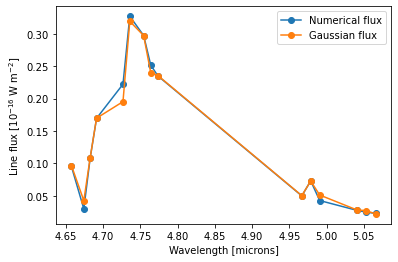

In [38]:
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(lineflux_data['wave'],lineflux_data['lineflux']*1e16, '-o', label='Numerical flux')
ax1.plot(lineflux_data['wave'],lineflux_data['lineflux_Gaussian']*1e16, '-o', label='Gaussian flux')
ax1.legend()
ax1.set_xlabel('Wavelength [microns]')
ax1.set_ylabel(r'Line flux [10$^{-16}$ W m$^{-2}$]')

### Create a composite lineshape using info from flux_calculator output

Flux calculator also has a routine that can make a composite lineshape from calc_fluxes output.

In [39]:
lineshape_data=make_lineshape(wave,flux,lineflux_data)

Text(0, 0.5, 'Arbitrary flux')

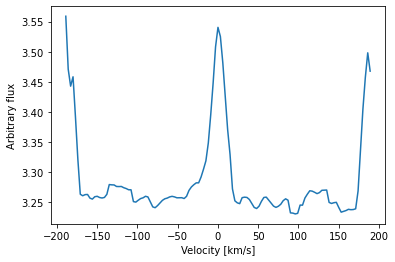

In [40]:
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(lineshape_data[0],lineshape_data[1])

ax1.set_xlabel('Velocity [km/s]')
ax1.set_ylabel('Arbitrary flux')

### Display resultant fluxes in a rotation diagram

Spectools_ir.utils has a function to make a rotation diagram, which can use calc_fluxes output as its dataset.  This example compares rotation diagrams for the Gaussian and numerical fluxes.

make_rotation_diagrams has a "units" keyword with values 'mks' (SI), 'cgs', or 'mixed'. Based on some precedent in the literature, 'mixed' units keeps most values in SI units, but wavenumbers in inverse cm.

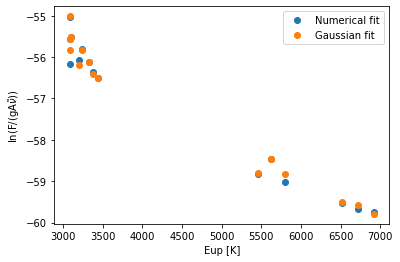

In [41]:
rot_numerical=make_rotation_diagram(lineflux_data,fluxkey='lineflux')
rot_Gaussian=make_rotation_diagram(lineflux_data,fluxkey='lineflux_Gaussian')

fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(rot_numerical['x'],rot_numerical['y'],'C0o',label='Numerical fit')
ax1.plot(rot_Gaussian['x'],rot_Gaussian['y'],'C1o', label='Gaussian fit')

ax1.set_xlabel('Eup [K]')
ax1.set_ylabel(r'ln(F/(gA$\tilde{\nu}$))')
ax1.legend()

# Slabspec example use

Slabspec makes a model spectrum from a "slab" of gas - a column of gas with defined area, column density, and (single) temperature. The example below shows the creation of a CO spectrum from 4.58 to 5.2 microns.  Units are assumed to be SI (mks).  If convol_fwhm is specified, the model output will be convolved with a Gaussian with the given FWHM value (in km/s).  Both the convolved and unconvolved spectra are included in the output.

**Important note**: The model can produce wonky output if the model resolution ('res' parameter: resolution in microns) is not sufficient.  It's highly recommended that one check the output of a model against a model with higher resolution to make sure the output remains the same.

### Make a slab model spectrum with make_spec

In [65]:
au=1.5e11
#Make slab model
#This can take a few seconds to run.  It is primarily limited by the convolution time.
model_output=make_spec('CO',10**(20.9),750,np.pi*(0.58*au)**2., wmin=4.58,wmax=5.2,convol_fwhm=30.,d_pc=135.,res=1e-5,vup=1)

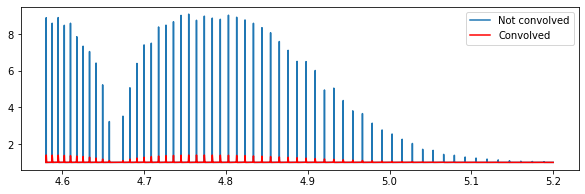

In [66]:
#Plot slab model
fig=plt.figure(figsize=(10,3))
ax1=fig.add_subplot(111)
ax1.plot(model_output['spectrum']['wave'],model_output['spectrum']['flux']+1,label='Not convolved')
ax1.plot(model_output['spectrum']['wave'],model_output['spectrum']['convolflux']+1,'r',label='Convolved')
ax1.legend()

### Output model fluxes as a rotation diagram (compare to data if desired)

Output from slabspec can also be displayed as a rotation diagram.

In [67]:
rd_model=make_rotation_diagram(model_output['lineparams'])
rd_data=make_rotation_diagram(lineflux_data)

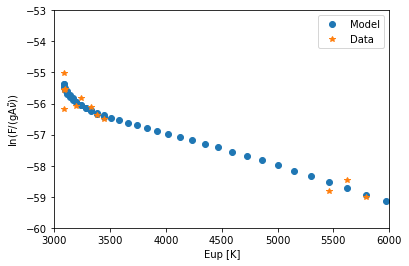

In [68]:
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(rd_model['x'],rd_model['y'],' C0o',label='Model')
ax1.plot(rd_data['x'],rd_data['y'],' C1*',label='Data')
ax1.set_xlabel('Eup [K]')
ax1.set_ylabel(r'ln(F/(gA$\tilde{\nu}$))')
ax1.set_xlim(3000,6000)
ax1.set_ylim(-60,-53)
ax1.legend()

# Slab_fitter example use

slab_fitter uses the MCMC fitting code "emcee" to fit line fluxes with a slab model.  Priors are assumed to be flat, with boundaries provided by the user as input parameters.

In contrast to the slab model, slab_fitter uses solid angle in place of area.  Helper functions calc_solid_angle(radius, distance) and calc_radius(solid_angle,distance) can be used to convert between the two.  Calculations assume a face-on disk shape.

### Set up configuration

Configuration parameters are all stored in config.json, or another user-specified json file.  User must specify the range of temperatures, column densities, and solid angles, the number of walkers, the number of burnin samples, and the number of samples per walker.

slab_fitter naturally takes output of flux_calculator as input. (Other input examples are discussed below).

In [75]:
myconfig=Config(config_file='/Users/erichegonzales/Desktop/eriche-thesis/data/hd135344.json') #reads config.json by default, or can specify path to file as input parameter
myconfig.display()

data=lineflux_data

mydata=LineData(data)
myretrieval=Retrieval(myconfig,mydata)

{
 "tmin": 600,
 "tmax": 900,
 "lognmin": 20.6,
 "lognmax": 22,
 "logomegamin": -15.8,
 "logomegamax": -14.55,
 "Nwalkers": 30,
 "Nburnin": 1000,
 "Nsamples": 4000
}


### Run retrieval

Running the retrieval can take a significant amount of time, so only run when ready. (Code below currently takes 9 minutes on my personal laptop.)

In [76]:
mychain=myretrieval.run_emcee()  #Run retrieval.  May take a while, depending on number of samples
pickle.dump(mychain,open('test_chain.p','wb'))  #Save for convenience and later retrieval
os.system('afplay /System/Library/Sounds/Sosumi.aiff')

mychain=pickle.load(open('test_chain.p','rb'))  
postsamples=get_samples(mychain,myconfig.getpar('Nburnin'))  #Get list of samples, after removing burnin, from chain

Number of total samples: 120000
Run time [s]: 181.01370191574097


### Evaluate retrieval results

slab_fitter includes a few simple routines for evaluating and viewing the retrieval results.

**Note:** The examples here are not necessarily well-behaved samples.  Users should refer to emcee documentation and other sources for more info about MCMC sample vetting.

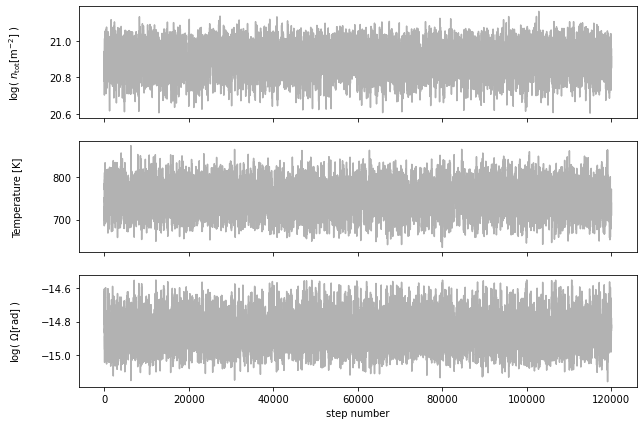

In [77]:
#Trace plot - examine samples
trace_plot(postsamples)

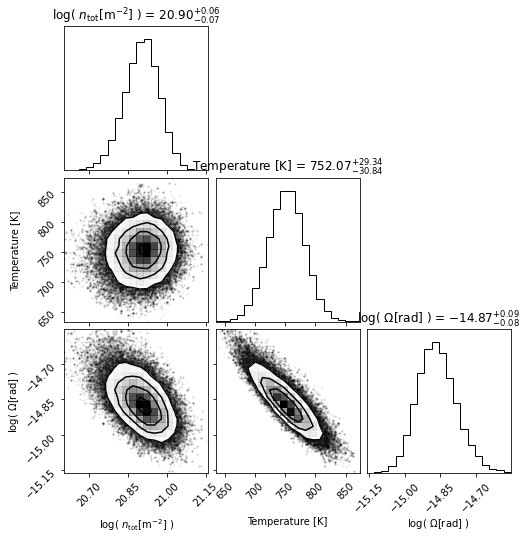

In [78]:
#Corner plot - see posterior distributions
fig=corner_plot(postsamples)

In [79]:
#Best fit parameters - best fit parameters plus/minus 1-sigma intervals
best_fit=find_best_fit(postsamples,show=True)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

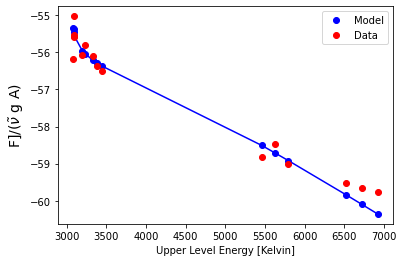

In [80]:
#Rotation diagram
modelflux=compute_model_fluxes(mydata,postsamples) #Compute model fluxes for ecah line in data
rotdiag=mydata.rot_diagram(modelfluxes=modelflux,units='mks') #Rotation diagram for data and model

fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(rotdiag['x'],rotdiag['modely'],'bo',label='Model')
ax1.plot(rotdiag['x'],rotdiag['modely'],'b',label='_None_')
ax1.plot(rotdiag['x'],rotdiag['y'],'ro',label='Data')

ax1.set_xlabel('Upper Level Energy [Kelvin]')
#ax1.set_ylabel(r'F[W m$^{-2}$]/($\~{\nu}$ [m$^{-1}$]g A[s$^{-1}$])',fontsize=14)
ax1.set_ylabel(r'F]/($\~{\nu}$ g A)',fontsize=14)
ax1.legend()